# Setup

In [1]:
import os
os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk@17'


In [2]:
!which java

/usr/bin/java


In [3]:
# df = df.sample(0.5)

In [4]:
from pyspark.sql import SparkSession
#trying everything to make it work faster
spark = SparkSession.builder \
    .appName("final_proj") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.memory.fraction", "0.6") \
    .config("spark.sql.shuffle.partitions", "50") \
    .config("spark.default.parallelism", "50") \
    .config("spark.sql.autoBroadcastJoinThreshold", "10m") \
    .config("spark.dynamicAllocation.enabled", "false") \
    .getOrCreate()

df = spark.range(5)
df.show()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/07 21:11:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



In [5]:
# import pyspark

# session = pyspark.sql.SparkSession
# spark = session.builder.config('spark.driver.memory','12g').getOrCreate()
# spark

In [6]:
import pandas as pd

In [7]:
# df = pd.read_csv("TrafficEvents_Aug16_Dec20_Publish.csv")

In [8]:
# len(df)

In [9]:
# from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# schema = StructType([
#     StructField("EventId", StringType(), True),
#     StructField("Type", StringType(), True),
#     StructField("Severity", IntegerType(), True),
#     StructField("TMC", IntegerType(), True), #more detailed description of event
#     StructField("Description", StringType(), True),
#     StructField("StartTime(UTC)", StringType(), True),
#     StructField("EndTime(UTC)", StringType(), True),
#     StructField("TimeZone", StringType(), True),
#     StructField("LocationLat", DoubleType(), True),
#     StructField("LocationLng", DoubleType(), True),
#     StructField("Distance(mi)", DoubleType(), True),
#     StructField("AirportCode", StringType(), True),
#     StructField("Number", IntegerType(), True),
#     StructField("Street", StringType(), True),
#     StructField("Side", StringType(), True),
#     StructField("City", StringType(), True),
#     StructField("County", StringType(), True),
#     StructField("State", StringType(), True),
#     StructField("ZipCode", IntegerType(), True),
    
#     # define all columns explicitly
# ])

In [10]:
# traffic_events = spark.read\
#     .option("header", True)\
#     .schema(schema)\
#     .option("mode", "DROPMALFORMED")\
#     .option("enforceSchema", "false")\
#     .csv("TrafficEvents_Aug16_Dec20_Publish.csv")
# traffic_events.show(1)

# Observe Main Datasets

In [11]:
traffic_events_csv = spark.read\
    .option("header", True)\
    .option("inferSchema", True)\
    .csv("TrafficEvents_Aug16_Dec20_Publish.csv")

In [12]:
traffic_events_csv.count()

31355575

In [13]:
# traffic_events3 = spark.read\
#     .option("header", True)\
#     .option("inferSchema", True)\
#     .option("mode", "PERMISSIVE")\
#     .option("columnNameOfCorruptRecord", "_corrupt_record")\
#     .csv("TrafficEvents_Aug16_Dec20_Publish.csv")

In [14]:
# traffic_events3.filter("`_corrupt_record` IS NOT NULL").count()

In [15]:
weather_events_csv = spark.read\
    .option("header", True)\
    .option("inferSchema", True)\
    .csv("WeatherEvents_Aug16_Dec20_Publish.csv")
weather_events_csv.show(5)

+-------+----+--------+-------------------+-------------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
|EventId|Type|Severity|     StartTime(UTC)|       EndTime(UTC)|   TimeZone|LocationLat|LocationLng|AirportCode|    City|  County|State|ZipCode|
+-------+----+--------+-------------------+-------------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
|  W-310|Rain|   Light|2016-08-01 00:16:00|2016-08-01 00:56:00|US/Mountain|    38.0972|  -106.1689|       K04V|Saguache|Saguache|   CO|  81149|
|  W-311|Rain|   Light|2016-08-01 01:16:00|2016-08-01 01:36:00|US/Mountain|    38.0972|  -106.1689|       K04V|Saguache|Saguache|   CO|  81149|
|  W-312|Rain|   Light|2016-08-01 01:56:00|2016-08-01 02:16:00|US/Mountain|    38.0972|  -106.1689|       K04V|Saguache|Saguache|   CO|  81149|
|  W-313|Rain|   Light|2016-08-01 02:36:00|2016-08-01 02:56:00|US/Mountain|    38.0972|  -106.1689|       K04V|Saguache|Saguache|   CO| 

In [16]:
weather_events_csv.count()

5576434

In [17]:
# traffic_events = traffic_events_csv.sample(0.1)

In [19]:
#parquet > csvs, turn into parquet and back
traffic_events_csv.select(["Type", "Severity", "StartTime(UTC)", "EndTime(UTC)", "City", "State"]).write.parquet("traffic_events")
traffic_events = spark.read.parquet("traffic_events")
weather_events_csv.select(["Type", "Severity", "StartTime(UTC)", "EndTime(UTC)", "City", "State"]).write.parquet("weather_events")
weather_events = spark.read.parquet("weather_events")

In [20]:
import matplotlib.pyplot as plt

In [21]:
# traffic_events_csv.show()

In [22]:
# traffic_events.select("Severity", "TMC", "Description" ).show(20, truncate = False)

# Basic Histogram Graphs, Determine Data Availability

In [23]:
severity_counts = traffic_events.groupBy("Severity").count().orderBy("Severity")
severity_pd = severity_counts.toPandas()

In [24]:
severity_counts.show()

+--------+--------+
|Severity|   count|
+--------+--------+
|       0| 5802732|
|       1|12673613|
|       2|10149277|
|       3| 2666083|
|       4|   63870|
+--------+--------+



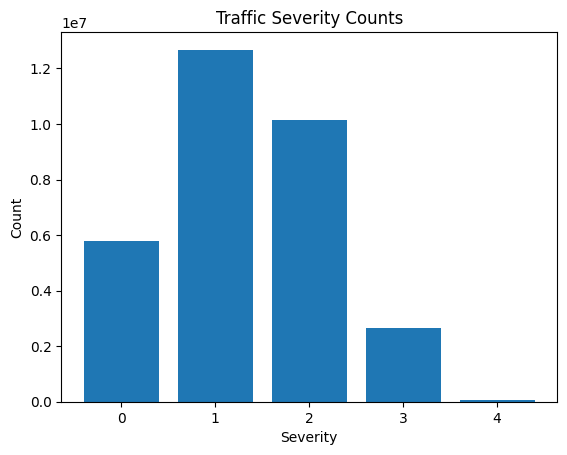

In [25]:
plt.bar(severity_pd["Severity"], severity_pd["count"])
plt.xlabel("Severity")
plt.ylabel("Count")
plt.title("Traffic Severity Counts")
plt.show()

In [26]:
from pyspark.sql.functions import col
cities_counts = traffic_events.groupBy("City").count().orderBy(col("count").desc()).limit(10)
cities_pd = cities_counts.toPandas()

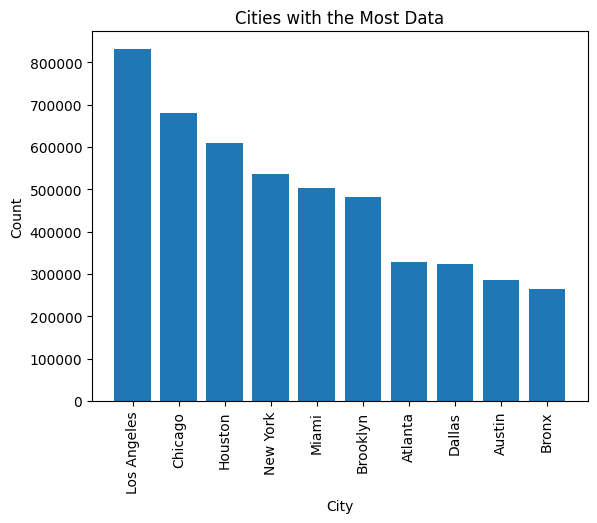

In [27]:
plt.bar(cities_pd["City"], cities_pd["count"])
plt.xlabel("City")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Cities with the Most Data")
plt.show()

In [28]:
from pyspark.sql.functions import col
cities_counts = traffic_events.filter(col("Type") == "Congestion").groupBy("State").count().orderBy(col("count").desc()).limit(10)
cities_pd = cities_counts.toPandas()

In [29]:
cities_pd.columns

Index(['State', 'count'], dtype='object')

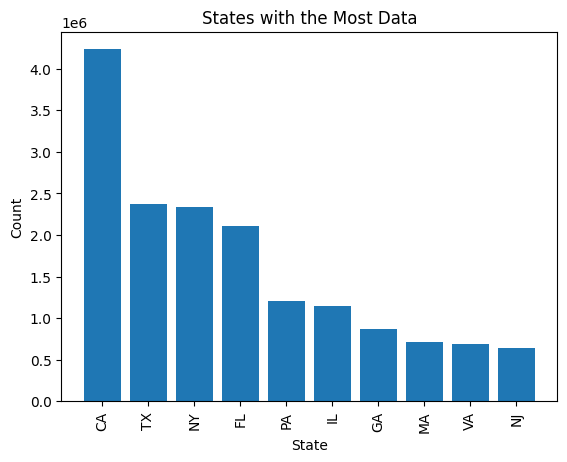

In [30]:
plt.bar(cities_pd["State"], cities_pd["count"])
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("States with the Most Data")
plt.show()

In [31]:
states_counts = traffic_events.groupBy("State").count().orderBy(col("count").desc()).limit(15)
states_pd = states_counts.toPandas()

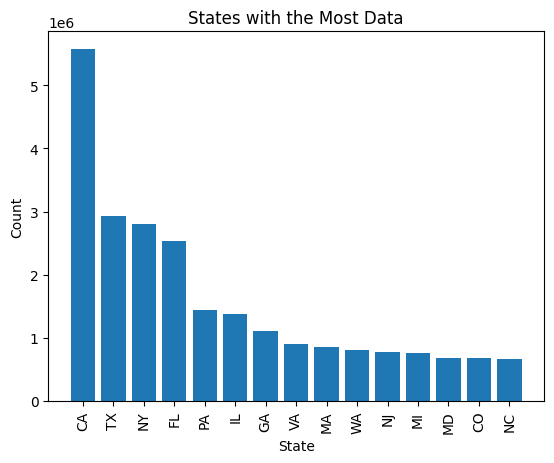

In [32]:
plt.bar(states_pd["State"], states_pd["count"])
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("States with the Most Data")
plt.show()

In [33]:
#Will compare LA, Chicago, Houston, NYC, Miami and Atlanta
#Compare severity of 

# Start Comparing Cities

In [34]:
from pyspark.sql.functions import when
weather_events = weather_events.withColumn(
    "WeatherSeverityNumeric",
    when(col("Severity") == "Light", 1)
    .when(col("Severity") == "Moderate", 2)
    .when(col("Severity") == "Heavy", 3)
    .otherwise(0)
)

In [35]:
#see congestion distribution in good and bad weather in Houston and Dallas.
houston_weather = weather_events.filter(col("City") == "Houston")
dallas_weather = weather_events.filter(col("City") == "Dallas")

In [36]:
houston_weather.show()

+----+--------+-------------------+-------------------+-------+-----+----------------------+
|Type|Severity|     StartTime(UTC)|       EndTime(UTC)|   City|State|WeatherSeverityNumeric|
+----+--------+-------------------+-------------------+-------+-----+----------------------+
|Rain|   Light|2016-08-01 22:07:00|2016-08-01 22:39:00|Houston|   TX|                     1|
|Rain|   Light|2016-08-11 22:39:00|2016-08-11 22:53:00|Houston|   TX|                     1|
|Rain|   Light|2016-08-14 00:35:00|2016-08-14 00:50:00|Houston|   TX|                     1|
|Rain|Moderate|2016-08-14 00:50:00|2016-08-14 01:17:00|Houston|   TX|                     2|
|Rain|   Heavy|2016-08-14 01:17:00|2016-08-14 03:18:00|Houston|   TX|                     3|
|Rain|Moderate|2016-08-14 03:18:00|2016-08-14 04:53:00|Houston|   TX|                     2|
|Rain|   Light|2016-08-14 04:53:00|2016-08-14 07:53:00|Houston|   TX|                     1|
|Rain|   Light|2016-08-14 10:53:00|2016-08-14 13:53:00|Houston|   TX| 

In [37]:
houston_congestion = traffic_events.filter(col("City") == "Houston").filter(col("Type") == "Congestion")
dallas_congestion = traffic_events.filter(col("City") == "Dallas").filter(col("Type") == "Congestion")

In [38]:
houston_congestion_counts = houston_congestion.groupBy("Severity").count().orderBy("Severity")
houston_congestion_pd = houston_congestion_counts.toPandas()

dallas_congestion_counts = dallas_congestion.groupBy("Severity").count().orderBy("Severity")
dallas_congestion_pd = dallas_congestion_counts.toPandas()

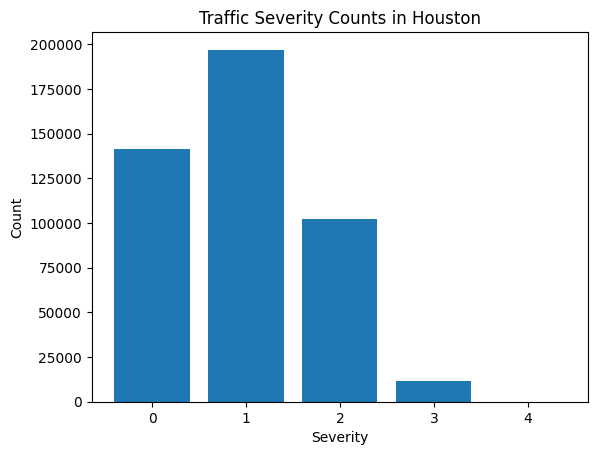

In [39]:
plt.bar(houston_congestion_pd["Severity"], houston_congestion_pd["count"])
plt.xlabel("Severity")
plt.ylabel("Count")
plt.title("Traffic Severity Counts in Houston")
plt.show()

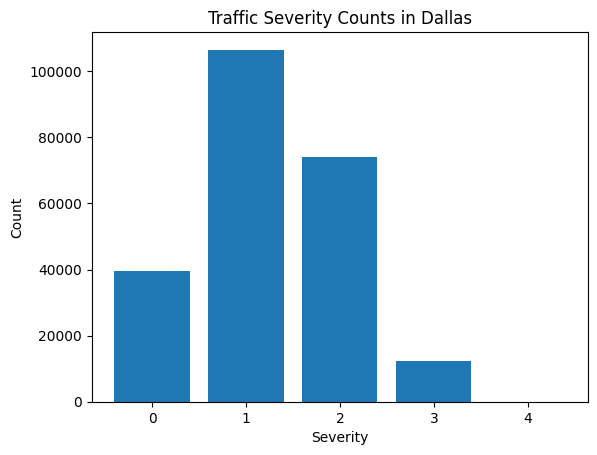

In [40]:
plt.bar(dallas_congestion_pd["Severity"], dallas_congestion_pd["count"])
plt.xlabel("Severity")
plt.ylabel("Count")
plt.title("Traffic Severity Counts in Dallas")
plt.show()

In [41]:
houston_congestion.show(1)

+----------+--------+-------------------+-------------------+-------+-----+
|      Type|Severity|     StartTime(UTC)|       EndTime(UTC)|   City|State|
+----------+--------+-------------------+-------------------+-------+-----+
|Congestion|       1|2020-06-01 06:22:00|2020-06-01 07:07:30|Houston|   TX|
+----------+--------+-------------------+-------------------+-------+-----+
only showing top 1 row


In [42]:
houston_weather.select("Type").distinct().show()

+-------------+
|         Type|
+-------------+
|         Rain|
|         Snow|
|          Fog|
|        Storm|
|         Cold|
|Precipitation|
|         Hail|
+-------------+



In [ ]:
# from pyspark.sql.functions import when #, isnull

# c = houston_congestion.alias("c")
# w = houston_weather.alias("w")

# houston_join_cols = c.join( #the start of the congestion was during some weather event
#     w,
#     (col("c.StartTime(UTC)") >= col("w.StartTime(UTC)")) &
#     (col("c.StartTime(UTC)") <= col("w.EndTime(UTC)")),
#     how="left"
# )

# houston_joined = houston_join_cols.select(
#     col("c.*"),
#     when(col("w.Type").isNull(), "No Weather Event") #add the weather column, no weather event if nothing happened at the start of the traffic event
#         .otherwise(col("w.Type")).alias("WeatherType"),
#     col("w.WeatherSeverityNumeric")
# )


In [ ]:
# c = dallas_congestion.alias("c")
# w = dallas_weather.alias("w")

# dallas_join_cols = c.join( #the start of the congestion was during some weather event
#     w,
#     (col("c.StartTime(UTC)") >= col("w.StartTime(UTC)")) &
#     (col("c.StartTime(UTC)") <= col("w.EndTime(UTC)")),
#     how="left"
# )

# dallas_joined = dallas_join_cols.select(
#     col("c.*"),
#     when(col("w.Type").isNull(), "No Weather Event") #just add the weather column, no weather event if nothing happened at the start of the traffic event
#     .otherwise(col("w.Type")).alias("WeatherType"),
#     col("w.WeatherSeverityNumeric")
# )

In [ ]:
# houston_joined.show(5)

+----------+--------+-------------------+-------------------+-------+-----+----------------+----------------------+
|      Type|Severity|     StartTime(UTC)|       EndTime(UTC)|   City|State|     WeatherType|WeatherSeverityNumeric|
+----------+--------+-------------------+-------------------+-------+-----+----------------+----------------------+
|Congestion|       1|2020-06-01 06:22:00|2020-06-01 07:07:30|Houston|   TX|            Rain|                     1|
|Congestion|       1|2020-06-01 06:22:00|2020-06-01 07:07:30|Houston|   TX|            Rain|                     1|
|Congestion|       1|2020-06-01 11:06:00|2020-06-01 12:37:42|Houston|   TX|No Weather Event|                  NULL|
|Congestion|       1|2020-06-01 13:44:00|2020-06-01 14:30:12|Houston|   TX|No Weather Event|                  NULL|
|Congestion|       0|2020-06-01 13:45:00|2020-06-01 14:59:52|Houston|   TX|No Weather Event|                  NULL|
+----------+--------+-------------------+-------------------+-------+---

In [ ]:
# from pyspark.sql.functions import avg
# houston_avg_severity = houston_joined.groupBy("WeatherType").agg(avg("Severity").alias("AvgSeverity"))
# houston_avg_severity.show()

+----------------+------------------+
|     WeatherType|       AvgSeverity|
+----------------+------------------+
|            Rain|0.9336490406458603|
|             Fog|1.0038713589402737|
|No Weather Event|0.9660946325929728|
|   Precipitation|0.9084699453551912|
|           Storm|0.9912280701754386|
|            Cold| 1.004092769440655|
|            Hail|1.3287553648068668|
|            Snow|1.5754189944134078|
+----------------+------------------+



In [47]:
dallas_avg_severity = dallas_joined.groupBy("WeatherType").agg(avg("Severity").alias("AvgSeverity"))
dallas_avg_severity.show()
dallas_avg_severity.toPandas().to_csv("dallas_avg_severity.csv")

+----------------+------------------+
|     WeatherType|       AvgSeverity|
+----------------+------------------+
|            Rain|1.2211964643010915|
|             Fog| 1.257566809390226|
|           Storm| 0.984251968503937|
|            Cold| 1.246800731261426|
|No Weather Event|1.2618392790171722|
|   Precipitation| 1.106837606837607|
|            Snow|1.1409802930773119|
|            Hail|               1.5|
+----------------+------------------+



In [48]:
def join_traffic_and_weather_data(c, w):
    #congestion and weather dfs
    join_cols = c.join( #the start of the congestion was during some weather event
        w,
        (col("c.StartTime(UTC)") >= col("w.StartTime(UTC)")) &
        (col("c.StartTime(UTC)") <= col("w.EndTime(UTC)")),
        how="left"
    )

    joined = join_cols.select(
        col("c.*"),
        when(col("w.Type").isNull(), "No Weather Event") #just add the weather column, no weather event if nothing happened at the start of the traffic event
        .otherwise(col("w.Type")).alias("WeatherType"),
        col("w.WeatherSeverityNumeric")
    )

    return joined

In [64]:
def get_specific_city_joined(city):
    city_congestion = traffic_events.filter(col("City") == city).filter(col("Type") == "Congestion")
    # city_congestion_counts = city_congestion.groupBy("Severity").count().orderBy("Severity")

    city_weather = weather_events.filter(col("City") == city)

    c = city_congestion.alias("c")
    w = city_weather.alias("w")

    city_joined = join_traffic_and_weather_data(c, w)
    return city_joined

In [49]:
def get_overall_joined_congestion_with_severity_data():
    congestion = traffic_events.filter(col("Type") == "Congestion")
    c = congestion.alias("c")
    w = weather_events.alias("w")

    joined = join_traffic_and_weather_data(c, w)
    # joined.show(5)
    return joined

In [65]:
def get_avg_congestion_severity(city):
    city_joined = get_specific_city_joined(city)

    city_avg_severity = city_joined.groupBy("WeatherType").agg(avg("Severity").alias("AvgSeverity"))
    # city_avg_severity.show()
    return city_avg_severity

In [76]:
la_avg_severity = get_avg_congestion_severity("Los Angeles")
la_avg_severity.show()

+----------------+------------------+
|     WeatherType|       AvgSeverity|
+----------------+------------------+
|            Rain|0.9336574654956086|
|             Fog|0.8710798031458072|
|            Cold|0.8181443298969072|
|No Weather Event|0.8704470917624155|
|   Precipitation|              0.75|
+----------------+------------------+



In [73]:
sf_avg_severity = get_avg_congestion_severity("San Francisco")
sf_avg_severity.show()

+----------------+------------------+
|     WeatherType|       AvgSeverity|
+----------------+------------------+
|            Rain|0.9878104875804968|
|             Fog|0.8165467625899281|
|No Weather Event| 0.879694487580227|
|           Storm|0.8709677419354839|
|            Cold|              0.75|
|   Precipitation|               0.5|
+----------------+------------------+



In [ ]:
dallas_avg_severity = get_avg_congestion_severity("Dallas")
dallas_avg_severity.to_pandas().to_csv("dallas")

+----------------+------------------+
|     WeatherType|       AvgSeverity|
+----------------+------------------+
|            Rain|1.2211964643010915|
|             Fog| 1.257566809390226|
|           Storm| 0.984251968503937|
|            Cold| 1.246800731261426|
|No Weather Event|1.2618392790171722|
|   Precipitation| 1.106837606837607|
|            Snow|1.1409802930773119|
|            Hail|               1.5|
+----------------+------------------+



In [54]:
houston_avg_severity = get_avg_congestion_severity("Houston")
houston_avg_severity.show()

+----------------+------------------+
|     WeatherType|       AvgSeverity|
+----------------+------------------+
|            Rain|0.9336490406458603|
|             Fog|1.0038713589402737|
|No Weather Event|0.9660946325929728|
|   Precipitation|0.9084699453551912|
|           Storm|0.9912280701754386|
|            Cold| 1.004092769440655|
|            Hail|1.3287553648068668|
|            Snow|1.5754189944134078|
+----------------+------------------+



In [55]:
boston_avg_severity = get_avg_congestion_severity("Boston")
boston_avg_severity.show()

+----------------+------------------+
|     WeatherType|       AvgSeverity|
+----------------+------------------+
|No Weather Event|1.0473979043914898|
+----------------+------------------+



In [56]:
# # Graph top few cities, graph percentage of events having rain vs. perent increase in congestion
# def compare_city_performance(rain_level = 1):

#     joined_data = get_overall_joined_congestion_with_severity_data()

#     base_df = joined_data.filter(col("City").isin("Los Angeles", "Chicago", "Houston", "New York", "Miami"))

#     df_small = base_df.select("City", "WeatherSeverityNumeric", "WeatherType", "Severity") \
#                     .na.drop(subset=["Severity", "WeatherSeverityNumeric", "WeatherType"])

#     agg_df = df_small.groupBy("City").agg(
#         avg(when(col("WeatherSeverityNumeric") == 1, col("Severity"))).alias("RainAvg"),
#         avg(when(col("WeatherType") == "No Weather Event", col("Severity"))).alias("NoEventAvg")
#     )

#     # Step 3: Calculate percent increase
#     # result_df = agg_df.withColumn(
#     #     "PercentIncrease",
#     #     ((col("RainAvg") - col("NoEventAvg")) / col("NoEventAvg")) * 100
#     # )

#     return agg_df


#     # Show final result
#     # result_df.show(truncate = False)

    

    
    

In [57]:
# result_df = compare_city_performance(1)
# result_df.show(10)

In [58]:
# congestion = traffic_events.filter(col("Type") == "Congestion")

# c = congestion.alias("c")
# w = weather_events.alias("w")

# joined = join_traffic_and_weather_data(c, w)
# joined.show()

In [68]:
# result_df.show(truncate=False)

In [60]:
# boston_joined.select("WeatherType").distinct().show()


In [61]:
# boston_avg_severity.toPandas().to_csv("boston_avg_severity.csv")

Why does the rain not change anything - makes things a bit better, ppl stay inside.
Try to only get rush hour times, where people have to go on the road

In [69]:
def average_for_city_weathertype_weatherseverity(city, weathertype, wseverity):
    city_joined = get_specific_city_joined(city)

    filtered = city_joined.filter(
        (col("WeatherType") == weathertype) &
        (col("WeatherSeverityNumeric") == wseverity)
    )

    specific_city_wtype_wseverity_avg = filtered.agg(avg("Severity").alias("AvgSeverity"))
    return specific_city_wtype_wseverity_avg

In [ ]:
specific_city_wtype_wseverity_avg = average_for_city_weathertype_weatherseverity("Boston", "Rain", 2)
specific_city_wtype_wseverity_avg.show()

ERROR:root:KeyboardInterrupt while sending command.           (1823 + 8) / 3100]
Traceback (most recent call last):
  File "/Users/johnathandagan/Documents/School_files/2024-2025/Big Data/Final Project/venv/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/johnathandagan/Documents/School_files/2024-2025/Big Data/Final Project/venv/lib/python3.12/site-packages/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

# Rush hour

In [ ]:
from pyspark.sql.functions import to_timestamp, from_utc_timestamp, hour, minute, dayofweek

# turn to houston time
houston_joined = houston_joined.withColumn("StartTimeLocal", from_utc_timestamp(to_timestamp(col("StartTime(UTC)")), "America/Chicago"))

houston_joined = houston_joined.withColumn("hour", hour("StartTimeLocal")) \
       .withColumn("minute", minute("StartTimeLocal")) \
       .withColumn("day", dayofweek("StartTimeLocal"))  # 1 = Sunday, 2 = Monday,..., 7 = Saturday
#get weekdays
houston_weekday = houston_joined.filter((col("day") >= 2) & (col("day") <= 6))
#get rush hour during weekdays (7:30-9:30 and 4:30-6:30 local time)
houston_rush_hour = houston_weekday.filter(
    (
        (col("hour") == 7) & (col("minute") >= 30) |
        (col("hour") == 8) |
        (col("hour") == 9) & (col("minute") <= 30)
    ) |
    (
        (col("hour") == 16) & (col("minute") >= 30) |
        (col("hour") == 17) |
        (col("hour") == 18) & (col("minute") <= 30)
    )
)


In [ ]:
# turn to dallas time
dallas_joined = dallas_joined.withColumn("StartTimeLocal", from_utc_timestamp(to_timestamp(col("StartTime(UTC)")), "America/Chicago"))

dallas_joined = dallas_joined.withColumn("hour", hour("StartTimeLocal")) \
       .withColumn("minute", minute("StartTimeLocal")) \
       .withColumn("day", dayofweek("StartTimeLocal"))  # 1 = Sunday, 2 = Monday,..., 7 = Saturday
#get weekdays
dallas_weekday = dallas_joined.filter((col("day") >= 2) & (col("day") <= 6))
#get rush hour during weekdays (7:30-9:30 and 4:30-6:30 local time)
dallas_rush_hour = dallas_weekday.filter(
    (
        (col("hour") == 7) & (col("minute") >= 30) |
        (col("hour") == 8) |
        (col("hour") == 9) & (col("minute") <= 30)
    ) |
    (
        (col("hour") == 16) & (col("minute") >= 30) |
        (col("hour") == 17) |
        (col("hour") == 18) & (col("minute") <= 30)
    )
)


In [ ]:
houston_rush_hour.show(10)

+---------+----------+--------+---+--------------------+-------------------+-------------------+----------+-----------+-----------+------------+-----------+------+--------------------+----+-------+------+-----+-------+----------------+----------------------+-------------------+----+------+---+
|  EventId|      Type|Severity|TMC|         Description|     StartTime(UTC)|       EndTime(UTC)|  TimeZone|LocationLat|LocationLng|Distance(mi)|AirportCode|Number|              Street|Side|   City|County|State|ZipCode|     WeatherType|WeatherSeverityNumeric|     StartTimeLocal|hour|minute|day|
+---------+----------+--------+---+--------------------+-------------------+-------------------+----------+-----------+-----------+------------+-----------+------+--------------------+----+-------+------+-----+-------+----------------+----------------------+-------------------+----+------+---+
|T-2426682|Congestion|       1| 72|Delays increasing...|2016-11-30 22:45:00|2016-11-30 23:03:07|US/Central|  29.785

In [ ]:
houston_rush_hour_avg_severity = houston_rush_hour.groupBy("WeatherType").agg(avg("Severity").alias("AvgSeverity"))
houston_rush_hour_avg_severity.show()

+----------------+------------------+
|     WeatherType|       AvgSeverity|
+----------------+------------------+
|            Cold|0.8905109489051095|
|No Weather Event|0.8509436253363243|
|             Fog|0.9106315940230104|
|           Storm|1.2647058823529411|
|   Precipitation|0.7437005039596832|
|            Rain|0.8058789514263686|
|            Hail| 1.391304347826087|
|            Snow| 1.513157894736842|
+----------------+------------------+



In [ ]:
dallas_rush_hour_avg_severity = dallas_rush_hour.groupBy("WeatherType").agg(avg("Severity").alias("AvgSeverity"))
dallas_rush_hour_avg_severity.show()

+----------------+------------------+
|     WeatherType|       AvgSeverity|
+----------------+------------------+
|No Weather Event|1.1927876200909102|
|             Fog| 1.172647355526733|
|            Rain|1.0952355345235534|
|           Storm|1.0208333333333333|
|   Precipitation| 0.980806142034549|
|            Snow| 1.162570888468809|
|            Cold|1.2064606741573034|
|            Hail|               1.5|
+----------------+------------------+



Check for severe rain, >= 2

In [ ]:
filtered = houston_joined.filter(
    (col("WeatherType") == "Rain") &
    (col("WeatherSeverityNumeric") == 3)
)

houston_severe_rain = filtered.agg(avg("Severity").alias("AvgSeverity"))
houston_severe_rain.show()

+-----------------+
|      AvgSeverity|
+-----------------+
|1.054054054054054|
+-----------------+



In [ ]:
filtered = houston_joined.filter(
    (col("WeatherType") == "Rain") &
    (col("WeatherSeverityNumeric") == 2)
)

houston_severe_rain = filtered.agg(avg("Severity").alias("AvgSeverity"))
houston_severe_rain.show()

ERROR:root:KeyboardInterrupt while sending command.              (24 + 8) / 496]
Traceback (most recent call last):
  File "/Users/johnathandagan/Documents/School_files/2024-2025/Big Data/Final Project/venv/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/johnathandagan/Documents/School_files/2024-2025/Big Data/Final Project/venv/lib/python3.12/site-packages/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
filtered = houston_joined.filter(
    (col("WeatherType") == "Rain") &
    (col("WeatherSeverityNumeric") == 1)
)

houston_severe_rain = filtered.agg(avg("Severity").alias("AvgSeverity"))
houston_severe_rain.show()

+-----------------+
|      AvgSeverity|
+-----------------+
|0.934848219528023|
+-----------------+

